# Detecting AI-Generated code vs Human written


The growing use of generative AI in programming education presents significant challenges to academic integrity, particularly in identifying AI-generated code submissions. While traditional methods—such as MOSS (Measure of Software Similarity) and TF-IDF-based clustering—are commonly used in plagiarism detection, they are not suitable for detecting AI-Generated vs. human-written code. 

In this study, we build and compare classification methods that uses TF-IDF and abstract syntax tree (AST), coupled with a contrastive representation learning classifier to enhance detection performance. Our method incorporates contrastive learning with a fully connected neural network, introducing a weighted loss function that optimally balances classification performance. Additionally, we design a robust training algorithm that computes the triplet loss for the contrastive learning network, ensuring superior feature separation between human and AI-generated code. To evaluate our models, we use datasets containing human-written code and AI-generated code with labeling and compare the results of Support Vector Machine (SVM), Random Forest, and our novel classifier with 2-fold cross-validation.

Dataset Link: https://github.com/marcoedingen/chatgpt-code-detection

In [1]:
import pandas as pd

In [2]:
import json


with open('data.jsonl', 'r') as file:
	lines = file.readlines()


new_data1 = pd.DataFrame([json.loads(line) for line in lines])
new_data1 = new_data1
display(new_data1)

,id,source,code,label,embedding
0,HED_HumanEval/20,HED,numbers.sort()\n closest_elements = (nu...,1,"[-0.0036959983, -0.0114569357, -0.0021148226, ..."
1,HED_HumanEval/20,HED,closest_pair = None\n distance = None\n...,0,"[-0.018761592, -0.0229485016, 0.0174498707, -0..."
2,HED_HumanEval/38,HED,"groups = [s[(3 * i):min((3 * i + 3), len(s...",1,"[0.008215094, 0.0169972107, 0.0059368731, 0.00..."
3,HED_HumanEval/38,HED,return encode_cyclic(encode_cyclic(s))\n,0,"[7.43296e-05, -0.0027988164, -0.0074754329, 0...."
4,HED_HumanEval/39,HED,# First we define a function to check if a...,1,"[0.0077454061, -0.017852217, -0.034409035, -0...."
...,...,...,...,...,...
40153,CodeContests_1548_D1. Gregor and the Odd Cows ...,CodeContests,import sys\ninput = lambda: sys.stdin.readline...,0,"[0.0322632119, -0.0027105846, 0.0103345159, 0...."
40154,CodeContests_1552_D. Array Differentiation,CodeContests,t = int(input())\n\nfor _ in range(t):\n n ...,1,"[0.0238384288, -0.0154414093, 4.6298e-06, -0.0..."
40155,CodeContests_1552_D. Array Differentiation,CodeContests,def get_power_set(s):\n power_set=[[]]\n for...,0,"[0.0359626412, -0.0155915609, 0.0139639415, -0..."
40156,CodeContests_1557_B. Moamen and k-subarrays,CodeContests,"def can_sort_array(t, test_cases):\n result...",1,"[0.0186608713, 0.0131772552, 0.019931633, -0.0..."


In [3]:
new_data = new_data1.copy()

# Exploring how many different column names we have

In [4]:
display(new_data['source'].unique())

array(['HED', 'APPS', 'MBPPD', 'MTrajK', 'HackerEarth', 'CodeChef',
       'CodeContests'], dtype=object)

# Add a new column to check which are compilable

In [5]:
def is_compilable(code):
    try:
        compile(code, '<string>', 'exec')
        return 1
    except:
        return 0

new_data['compilable'] = new_data['code'].apply(is_compilable)
display(new_data)

<string>:1: SyntaxWarning: invalid decimal literal
<string>:1: SyntaxWarning: invalid decimal literal
<string>:1: SyntaxWarning: invalid decimal literal
<string>:1: SyntaxWarning: invalid decimal literal
<string>:1: SyntaxWarning: invalid decimal literal
<string>:1: SyntaxWarning: invalid decimal literal
<string>:5: SyntaxWarning: "is" with a literal. Did you mean "=="?
<string>:5: SyntaxWarning: "is" with a literal. Did you mean "=="?
<string>:1: SyntaxWarning: invalid decimal literal
<string>:2: SyntaxWarning: "is" with a literal. Did you mean "=="?
<string>:1: SyntaxWarning: invalid decimal literal
<string>:5: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<string>:2: SyntaxWarning: invalid decimal literal
<string>:5: SyntaxWarning: "is" with a literal. Did you mean "=="?
<string>:1: SyntaxWarning: invalid decimal literal
<string>:1: SyntaxWarning: invalid decimal literal
<string>:1: SyntaxWarning: invalid decimal literal
<string>:1: SyntaxWarning: invalid decimal litera

,id,source,code,label,embedding,compilable
0,HED_HumanEval/20,HED,numbers.sort()\n closest_elements = (nu...,1,"[-0.0036959983, -0.0114569357, -0.0021148226, ...",0
1,HED_HumanEval/20,HED,closest_pair = None\n distance = None\n...,0,"[-0.018761592, -0.0229485016, 0.0174498707, -0...",0
2,HED_HumanEval/38,HED,"groups = [s[(3 * i):min((3 * i + 3), len(s...",1,"[0.008215094, 0.0169972107, 0.0059368731, 0.00...",0
3,HED_HumanEval/38,HED,return encode_cyclic(encode_cyclic(s))\n,0,"[7.43296e-05, -0.0027988164, -0.0074754329, 0....",0
4,HED_HumanEval/39,HED,# First we define a function to check if a...,1,"[0.0077454061, -0.017852217, -0.034409035, -0....",1
...,...,...,...,...,...,...
40153,CodeContests_1548_D1. Gregor and the Odd Cows ...,CodeContests,import sys\ninput = lambda: sys.stdin.readline...,0,"[0.0322632119, -0.0027105846, 0.0103345159, 0....",1
40154,CodeContests_1552_D. Array Differentiation,CodeContests,t = int(input())\n\nfor _ in range(t):\n n ...,1,"[0.0238384288, -0.0154414093, 4.6298e-06, -0.0...",1
40155,CodeContests_1552_D. Array Differentiation,CodeContests,def get_power_set(s):\n power_set=[[]]\n for...,0,"[0.0359626412, -0.0155915609, 0.0139639415, -0...",1
40156,CodeContests_1557_B. Moamen and k-subarrays,CodeContests,"def can_sort_array(t, test_cases):\n result...",1,"[0.0186608713, 0.0131772552, 0.019931633, -0.0...",1


# Dropping embedding column as don't need that

In [6]:
new_data = new_data.drop(columns=['embedding'])
display(new_data)

,id,source,code,label,compilable
0,HED_HumanEval/20,HED,numbers.sort()\n closest_elements = (nu...,1,0
1,HED_HumanEval/20,HED,closest_pair = None\n distance = None\n...,0,0
2,HED_HumanEval/38,HED,"groups = [s[(3 * i):min((3 * i + 3), len(s...",1,0
3,HED_HumanEval/38,HED,return encode_cyclic(encode_cyclic(s))\n,0,0
4,HED_HumanEval/39,HED,# First we define a function to check if a...,1,1
...,...,...,...,...,...
40153,CodeContests_1548_D1. Gregor and the Odd Cows ...,CodeContests,import sys\ninput = lambda: sys.stdin.readline...,0,1
40154,CodeContests_1552_D. Array Differentiation,CodeContests,t = int(input())\n\nfor _ in range(t):\n n ...,1,1
40155,CodeContests_1552_D. Array Differentiation,CodeContests,def get_power_set(s):\n power_set=[[]]\n for...,0,1
40156,CodeContests_1557_B. Moamen and k-subarrays,CodeContests,"def can_sort_array(t, test_cases):\n result...",1,1


# Checking how many not compilable rows we have

In [7]:
compilable_counts = new_data['compilable'].value_counts()
print(compilable_counts)

1    39657
0      501
Name: compilable, dtype: int64


# Graph to show number of compilable and not complilable

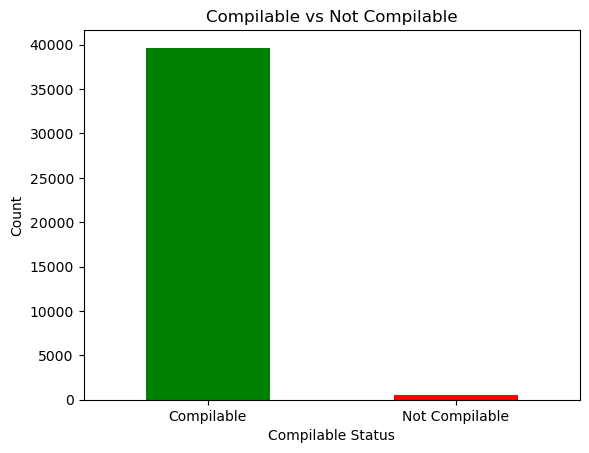

In [8]:
import matplotlib.pyplot as plt

# Bar plot for compilable and not compilable counts
compilable_counts.plot(kind='bar', color=['green', 'red'])
plt.title('Compilable vs Not Compilable')
plt.xlabel('Compilable Status')
plt.ylabel('Count')
plt.xticks(ticks=[1, 0], labels=['Not Compilable', 'Compilable'], rotation=0)
plt.savefig("compile.pdf")
plt.show()

# Dropping the records that are not compilable as we need the compilable codes

In [9]:
new_data = new_data[new_data['compilable'] != 0]
display(new_data)

,id,source,code,label,compilable
4,HED_HumanEval/39,HED,# First we define a function to check if a...,1,1
210,HED_HumanEval/83,HED,# Plan:\n# 1. Initialize count to 0.\n# 2....,1,1
232,HED_HumanEval/122,HED,"\ndef add_elements(arr, k):\n total = 0...",1,1
254,APPS_15,APPS,"t = int(input())\nfor _ in range(t):\n a, b...",1,1
255,APPS_15,APPS,"t = int(input())\nfor _ in range(t):\n\ta, b, ...",0,1
...,...,...,...,...,...
40153,CodeContests_1548_D1. Gregor and the Odd Cows ...,CodeContests,import sys\ninput = lambda: sys.stdin.readline...,0,1
40154,CodeContests_1552_D. Array Differentiation,CodeContests,t = int(input())\n\nfor _ in range(t):\n n ...,1,1
40155,CodeContests_1552_D. Array Differentiation,CodeContests,def get_power_set(s):\n power_set=[[]]\n for...,0,1
40156,CodeContests_1557_B. Moamen and k-subarrays,CodeContests,"def can_sort_array(t, test_cases):\n result...",1,1


# Looking how many of the records are human written vs AI-generated

In [10]:
Human_counts = new_data['label'].value_counts()
print(Human_counts)

0    19871
1    19786
Name: label, dtype: int64


# Checking how many labels are zeros and ones

In [11]:
label_counts = new_data['label'].value_counts()
print(label_counts)

0    19871
1    19786
Name: label, dtype: int64


# Droping id and source columns

In [12]:
new_data = new_data.drop(columns=['source', 'id'])
display(new_data)

,code,label,compilable
4,# First we define a function to check if a...,1,1
210,# Plan:\n# 1. Initialize count to 0.\n# 2....,1,1
232,"\ndef add_elements(arr, k):\n total = 0...",1,1
254,"t = int(input())\nfor _ in range(t):\n a, b...",1,1
255,"t = int(input())\nfor _ in range(t):\n\ta, b, ...",0,1
...,...,...,...
40153,import sys\ninput = lambda: sys.stdin.readline...,0,1
40154,t = int(input())\n\nfor _ in range(t):\n n ...,1,1
40155,def get_power_set(s):\n power_set=[[]]\n for...,0,1
40156,"def can_sort_array(t, test_cases):\n result...",1,1


In [13]:
import ast
import re
import numpy as np

def extract_all_ast_features(code):
    parsed_code = ast.parse(code)
    lines = code.splitlines()
    
    # Token analysis function
    
    
    class CodeVisitor(ast.NodeVisitor):
        def __init__(self):
            self.function_count = 0
            self.function_lengths = []
            self.if_count = 0
            self.while_count = 0
            self.for_count = 0
            self.try_count = 0
            self.with_count = 0
            self.lambda_count = 0
            self.decorator_count = 0
            self.list_comp_count = 0
            self.print_count = 0
            self.depth = 0
            self.max_depth = 0

        def generic_visit(self, node, depth=0):
            self.depth = depth
            self.max_depth = max(self.max_depth, depth)
            super().generic_visit(node)

        def visit_FunctionDef(self, node):
            self.function_count += 1
            self.function_lengths.append(len(node.body))
            self.generic_visit(node, self.depth + 1)

        def visit_If(self, node): 
            self.if_count += 1
            self.generic_visit(node, self.depth + 1)
            
        def visit_While(self, node): 
            self.while_count += 1
            self.generic_visit(node, self.depth + 1)

        def visit_Import(self, node):
            self.import_count += 1
            self.generic_visit(node, self.depth + 1)

        def visit_ImportFrom(self, node):
            self.import_count += 1
            self.generic_visit(node, self.depth + 1)
       

        def visit_For(self, node): 
            self.for_count += 1
            self.generic_visit(node, self.depth + 1)
            
        def visit_Try(self, node): 
            self.try_count += 1
            self.generic_visit(node, self.depth + 1)
            
        def visit_With(self, node): 
            self.with_count += 1
            self.generic_visit(node, self.depth + 1)
            
        def visit_Lambda(self, node): 
            self.lambda_count += 1
            self.generic_visit(node, self.depth + 1)
            
        def visit_Expr(self, node):
            if isinstance(node.value, ast.Call) and getattr(node.value.func, 'id', '') == 'print':
                self.print_count += 1
            self.generic_visit(node, self.depth + 1)
            
        def visit_ListComp(self, node):
            self.list_comp_count += 1
            self.generic_visit(node, self.depth + 1)

    visitor = CodeVisitor()
    try:
        visitor.visit(parsed_code)
    except:
        pass

    features = {
        # Line-based features
        'line_count': len(lines),
        'empty_line_count': sum(1 for line in lines if not line.strip()),
        'avg_line_length': sum(len(line) for line in lines) / max(1, len(lines)),
        'comment_lines': sum(1 for line in lines if line.strip().startswith('#')),
        'comment_density': sum(1 for line in lines if line.strip().startswith('#')) / max(1, len(lines)),
        
        # Code style features
        'snake_case_count': len(re.compile(r'\b[a-z]+(?:_[a-z]+)+\b').findall(code)),
        'generic_name_count': sum(code.count(name) for name in ['data', 'result', 'input', 'output', 'temp', 'value', 'var', 'x', 'y', 'z']),
        'has_docstring': int('"""' in code or "'''" in code),
        

        
        # AST-based features
        'function_count': visitor.function_count,
        'avg_function_length': sum(visitor.function_lengths) / max(1, len(visitor.function_lengths)),
        'if_count': visitor.if_count,
        'while_count': visitor.while_count,
        'for_count': visitor.for_count,
        'try_count': visitor.try_count,
        'with_count': visitor.with_count,
        'lambda_count': visitor.lambda_count,
        'decorator_count': visitor.decorator_count,
        'list_comp_count': visitor.list_comp_count,
        'print_count': visitor.print_count,
        'ast_max_depth': visitor.max_depth
    }
    
    return features


new_data['ast_features'] = new_data['code'].apply(extract_all_ast_features)


features_df = pd.DataFrame(new_data['ast_features'].tolist())
new_data = pd.concat([new_data, features_df], axis=1)
new_data = new_data.drop('ast_features', axis=1)

<unknown>:1: SyntaxWarning: invalid decimal literal
<unknown>:1: SyntaxWarning: invalid decimal literal
<unknown>:1: SyntaxWarning: invalid decimal literal
<unknown>:1: SyntaxWarning: invalid decimal literal
<unknown>:1: SyntaxWarning: invalid decimal literal
<unknown>:1: SyntaxWarning: invalid decimal literal
<unknown>:1: SyntaxWarning: invalid decimal literal
<unknown>:1: SyntaxWarning: invalid decimal literal
<unknown>:2: SyntaxWarning: invalid decimal literal
<unknown>:1: SyntaxWarning: invalid decimal literal
<unknown>:1: SyntaxWarning: invalid decimal literal
<unknown>:1: SyntaxWarning: invalid decimal literal
<unknown>:1: SyntaxWarning: invalid decimal literal
<unknown>:1: SyntaxWarning: invalid decimal literal
<unknown>:1: SyntaxWarning: invalid decimal literal
<unknown>:1: SyntaxWarning: invalid decimal literal
<unknown>:1: SyntaxWarning: invalid decimal literal
<unknown>:1: SyntaxWarning: invalid decimal literal
<unknown>:1: SyntaxWarning: invalid decimal literal
<unknown>:2:

In [14]:
new_data = new_data.dropna()
display(new_data)

,code,label,compilable,line_count,empty_line_count,avg_line_length,comment_lines,comment_density,snake_case_count,generic_name_count,...,if_count,while_count,for_count,try_count,with_count,lambda_count,decorator_count,list_comp_count,print_count,ast_max_depth
4,# First we define a function to check if a...,1.0,1.0,7.0,1.0,20.000000,0.0,0.000000,0.0,11.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
210,# Plan:\n# 1. Initialize count to 0.\n# 2....,1.0,1.0,30.0,5.0,23.900000,0.0,0.000000,22.0,33.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
232,"\ndef add_elements(arr, k):\n total = 0...",1.0,1.0,28.0,4.0,21.571429,0.0,0.000000,5.0,3.0,...,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
254,"t = int(input())\nfor _ in range(t):\n a, b...",1.0,1.0,13.0,1.0,19.692308,3.0,0.230769,0.0,1.0,...,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
255,"t = int(input())\nfor _ in range(t):\n\ta, b, ...",0.0,1.0,21.0,4.0,47.809524,9.0,0.428571,0.0,21.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39652,"from sys import stdin,stdout\n\nimport bisect...",0.0,1.0,21.0,3.0,18.523810,0.0,0.000000,0.0,13.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39653,"n, m = [int(i) for i in input().split()]\n\na ...",0.0,1.0,23.0,5.0,24.478261,4.0,0.173913,3.0,12.0,...,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0
39654,"n, m = map(int, input().split())\na = list(map...",1.0,1.0,34.0,2.0,22.176471,2.0,0.058824,9.0,7.0,...,4.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0
39655,"def largest_subrectangle(n, m, a, b, x):\n ...",1.0,1.0,37.0,7.0,32.189189,1.0,0.027027,13.0,28.0,...,4.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


In [15]:
display(new_data)

,code,label,compilable,line_count,empty_line_count,avg_line_length,comment_lines,comment_density,snake_case_count,generic_name_count,...,if_count,while_count,for_count,try_count,with_count,lambda_count,decorator_count,list_comp_count,print_count,ast_max_depth
4,# First we define a function to check if a...,1.0,1.0,7.0,1.0,20.000000,0.0,0.000000,0.0,11.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
210,# Plan:\n# 1. Initialize count to 0.\n# 2....,1.0,1.0,30.0,5.0,23.900000,0.0,0.000000,22.0,33.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
232,"\ndef add_elements(arr, k):\n total = 0...",1.0,1.0,28.0,4.0,21.571429,0.0,0.000000,5.0,3.0,...,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
254,"t = int(input())\nfor _ in range(t):\n a, b...",1.0,1.0,13.0,1.0,19.692308,3.0,0.230769,0.0,1.0,...,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
255,"t = int(input())\nfor _ in range(t):\n\ta, b, ...",0.0,1.0,21.0,4.0,47.809524,9.0,0.428571,0.0,21.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39652,"from sys import stdin,stdout\n\nimport bisect...",0.0,1.0,21.0,3.0,18.523810,0.0,0.000000,0.0,13.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39653,"n, m = [int(i) for i in input().split()]\n\na ...",0.0,1.0,23.0,5.0,24.478261,4.0,0.173913,3.0,12.0,...,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0
39654,"n, m = map(int, input().split())\na = list(map...",1.0,1.0,34.0,2.0,22.176471,2.0,0.058824,9.0,7.0,...,4.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0
39655,"def largest_subrectangle(n, m, a, b, x):\n ...",1.0,1.0,37.0,7.0,32.189189,1.0,0.027027,13.0,28.0,...,4.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


In [16]:
new_data = new_data.dropna()
display(new_data)

,code,label,compilable,line_count,empty_line_count,avg_line_length,comment_lines,comment_density,snake_case_count,generic_name_count,...,if_count,while_count,for_count,try_count,with_count,lambda_count,decorator_count,list_comp_count,print_count,ast_max_depth
4,# First we define a function to check if a...,1.0,1.0,7.0,1.0,20.000000,0.0,0.000000,0.0,11.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
210,# Plan:\n# 1. Initialize count to 0.\n# 2....,1.0,1.0,30.0,5.0,23.900000,0.0,0.000000,22.0,33.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
232,"\ndef add_elements(arr, k):\n total = 0...",1.0,1.0,28.0,4.0,21.571429,0.0,0.000000,5.0,3.0,...,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
254,"t = int(input())\nfor _ in range(t):\n a, b...",1.0,1.0,13.0,1.0,19.692308,3.0,0.230769,0.0,1.0,...,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
255,"t = int(input())\nfor _ in range(t):\n\ta, b, ...",0.0,1.0,21.0,4.0,47.809524,9.0,0.428571,0.0,21.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39652,"from sys import stdin,stdout\n\nimport bisect...",0.0,1.0,21.0,3.0,18.523810,0.0,0.000000,0.0,13.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39653,"n, m = [int(i) for i in input().split()]\n\na ...",0.0,1.0,23.0,5.0,24.478261,4.0,0.173913,3.0,12.0,...,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0
39654,"n, m = map(int, input().split())\na = list(map...",1.0,1.0,34.0,2.0,22.176471,2.0,0.058824,9.0,7.0,...,4.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0
39655,"def largest_subrectangle(n, m, a, b, x):\n ...",1.0,1.0,37.0,7.0,32.189189,1.0,0.027027,13.0,28.0,...,4.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


# Split data X and y

In [17]:
X = new_data.drop(columns=['label', 'code', 'compilable'])
y = new_data['label']


# Looking at Correlations

In [18]:
numeric_data = new_data.select_dtypes(include=['number'])

correlation_with_label = numeric_data.corr()['label'].sort_values(ascending=False)
print(correlation_with_label)

label                  1.000000
with_count             0.007162
line_count             0.006594
generic_name_count     0.005081
snake_case_count       0.004573
if_count               0.004353
avg_function_length    0.004113
avg_line_length        0.003284
empty_line_count       0.001459
list_comp_count        0.000938
lambda_count           0.000084
comment_lines         -0.000483
function_count        -0.002542
try_count             -0.003378
for_count             -0.003680
while_count           -0.005655
comment_density       -0.008477
has_docstring         -0.008561
print_count           -0.013578
ast_max_depth         -0.018310
compilable                  NaN
decorator_count             NaN
Name: label, dtype: float64


In [19]:
X_c = X
y_c = y

# Support Vectore Machine (kernel = rbf) using AST (2 fold corss-validation)

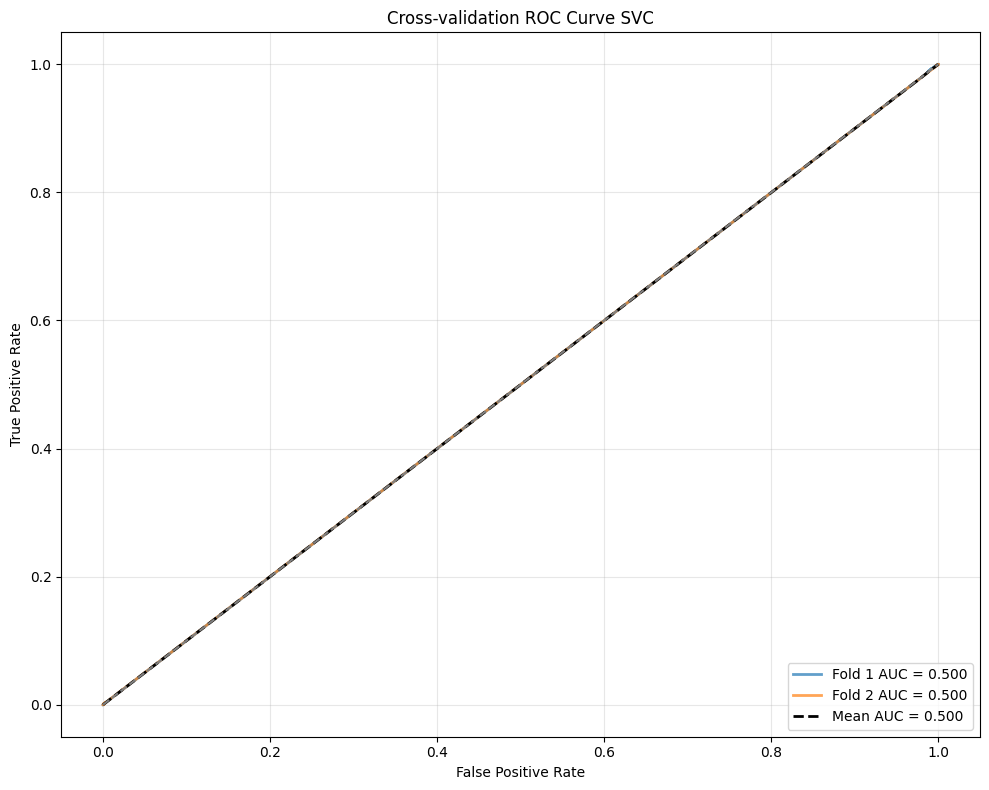

Fold 1:
  Accuracy:  0.502
  Precision: 0.519
  Recall:    0.018
  F1 Score:  0.035
  AUC:       0.500

Fold 2:
  Accuracy:  0.507
  Precision: 0.521
  Recall:    0.141
  F1 Score:  0.222
  AUC:       0.500

Average Metrics:
  Accuracy:  0.504
  Precision: 0.520
  Recall:    0.080
  F1 Score:  0.128
  AUC:       0.500


In [54]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC


svc_clf = SVC(kernel='rbf', probability=True, random_state=42)

cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

accuracies = []
precisions = []
recalls = []
f1_scores = []
aucs = []


plt.figure(figsize=(10, 8))
tprs = []
mean_fpr = np.linspace(0, 1, 100)

X_np = X.values
y_np = y.values


for i, (train_idx, test_idx) in enumerate(cv.split(X_np, y_np)):
    X_train, X_test = X_np[train_idx], X_np[test_idx]
    y_train, y_test = y_np[train_idx], y_np[test_idx]
    
    svc_clf.fit(X_train, y_train)
    

    y_pred = svc_clf.predict(X_test)
    y_prob = svc_clf.predict_proba(X_test)[:, 1]
    

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    

    accuracies.append(acc)
    precisions.append(prec)
    recalls.append(rec)
    f1_scores.append(f1)
    aucs.append(roc_auc)
    

    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    

    plt.plot(fpr, tpr, lw=2, alpha=0.7, label=f'Fold {i+1} AUC = {roc_auc:.3f}')


mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='black', linestyle='--', label=f'Mean AUC = {mean_auc:.3f}', lw=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Cross-validation ROC Curve SVC')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


for i in range(2):
    print(f"Fold {i+1}:")
    print(f"  Accuracy:  {accuracies[i]:.3f}")
    print(f"  Precision: {precisions[i]:.3f}")
    print(f"  Recall:    {recalls[i]:.3f}")
    print(f"  F1 Score:  {f1_scores[i]:.3f}")
    print(f"  AUC:       {aucs[i]:.3f}")
    print()


print("Average Metrics:")
print(f"  Accuracy:  {np.mean(accuracies):.3f}")
print(f"  Precision: {np.mean(precisions):.3f}")
print(f"  Recall:    {np.mean(recalls):.3f}")
print(f"  F1 Score:  {np.mean(f1_scores):.3f}")
print(f"  AUC:       {np.mean(aucs):.3f}")

# Random Forest using AST (2 fold corss-validation)

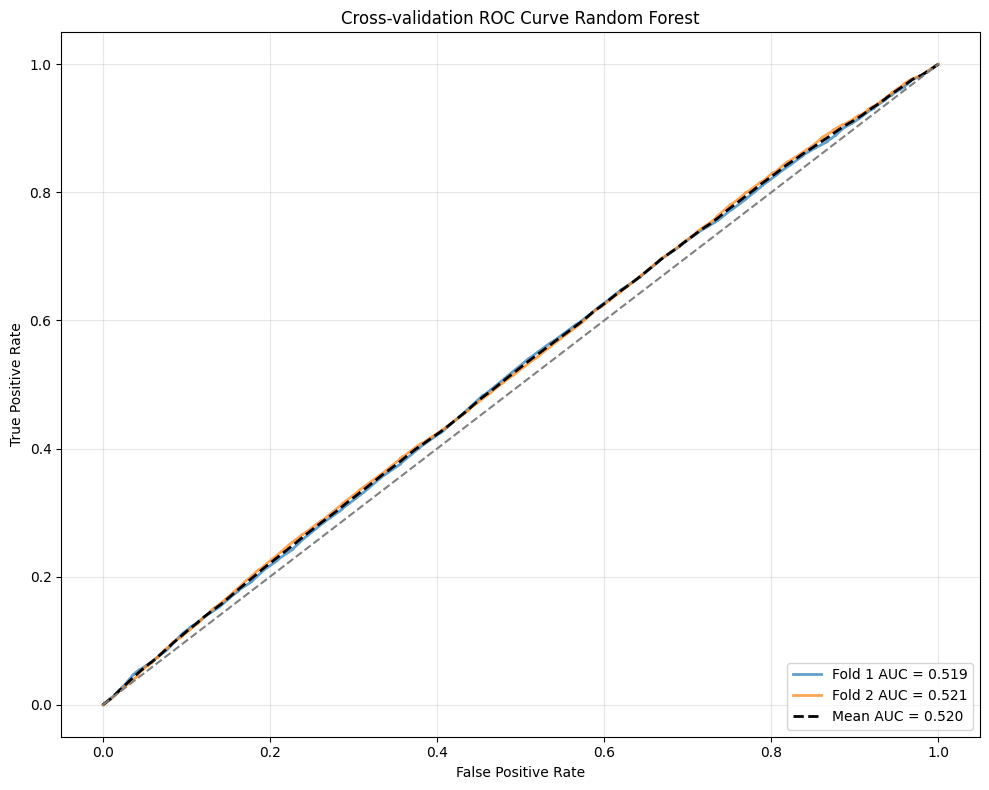

Fold 1:
  Accuracy:  0.514
  Precision: 0.513
  Recall:    0.485
  F1 Score:  0.499
  AUC:       0.519

Fold 2:
  Accuracy:  0.512
  Precision: 0.511
  Recall:    0.490
  F1 Score:  0.501
  AUC:       0.521

Average Metrics:
  Accuracy:  0.513
  Precision: 0.512
  Recall:    0.488
  F1 Score:  0.500
  AUC:       0.520


In [55]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import numpy as np

import matplotlib.pyplot as plt

rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)

cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)


accuracies = []
precisions = []
recalls = []
f1_scores = []
aucs = []


plt.figure(figsize=(10, 8))
tprs = []
mean_fpr = np.linspace(0, 1, 100)

X_np = X.values
y_np = y.values

for i, (train_idx, test_idx) in enumerate(cv.split(X_np, y_np)):
    X_train, X_test = X_np[train_idx], X_np[test_idx]
    y_train, y_test = y_np[train_idx], y_np[test_idx]
    

    rf_clf.fit(X_train, y_train)
    

    y_pred = rf_clf.predict(X_test)
    y_prob = rf_clf.predict_proba(X_test)[:, 1]
  
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    

    accuracies.append(acc)
    precisions.append(prec)
    recalls.append(rec)
    f1_scores.append(f1)
    aucs.append(roc_auc)

    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    

    plt.plot(fpr, tpr, lw=2, alpha=0.7, label=f'Fold {i+1} AUC = {roc_auc:.3f}')


mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='black', linestyle='--', label=f'Mean AUC = {mean_auc:.3f}', lw=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Cross-validation ROC Curve Random Forest')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


for i in range(2):
    print(f"Fold {i+1}:")
    print(f"  Accuracy:  {accuracies[i]:.3f}")
    print(f"  Precision: {precisions[i]:.3f}")
    print(f"  Recall:    {recalls[i]:.3f}")
    print(f"  F1 Score:  {f1_scores[i]:.3f}")
    print(f"  AUC:       {aucs[i]:.3f}")
    print()

print("Average Metrics:")
print(f"  Accuracy:  {np.mean(accuracies):.3f}")
print(f"  Precision: {np.mean(precisions):.3f}")
print(f"  Recall:    {np.mean(recalls):.3f}")
print(f"  F1 Score:  {np.mean(f1_scores):.3f}")
print(f"  AUC:       {np.mean(aucs):.3f}")

# Using AST + TFIDF

In [20]:
import ast
from tqdm import tqdm
import os

MAX_CONTEXTS = 200

def get_leaf_nodes(node, leaves=None):
    if leaves is None:
        leaves = []
    if isinstance(node, ast.AST):
        children = list(ast.iter_child_nodes(node))
        if not children:
            leaves.append(node)
        for child in children:
            get_leaf_nodes(child, leaves)
    return leaves

def get_path(a, b):
    return f'{type(a).__name__}→...←{type(b).__name__}'

def extract_paths_from_code(code):
    try:
        tree = ast.parse(code)
        leaves = get_leaf_nodes(tree)
        contexts = []
        for i in range(min(len(leaves), MAX_CONTEXTS)):
            for j in range(i+1, min(len(leaves), MAX_CONTEXTS)):
                a, b = leaves[i], leaves[j]
                start = getattr(a, 'id', getattr(a, 'attr', 'X'))
                end = getattr(b, 'id', getattr(b, 'attr', 'Y'))
                path = get_path(a, b)
                contexts.append(f"{start},{path},{end}")
                if len(contexts) >= MAX_CONTEXTS:
                    return contexts
        return contexts
    except Exception as e:
        print("AST parse error:", e)
        return []

# def convert_dataframe_to_code2seq_format(df, output_file):
#     with open(output_file, 'w') as out_f:
#         for _, row in tqdm(df.iterrows(), total=len(df)):
#             label = 'human' if row['label'] == 0 else 'ai'
#             code = row['code']
#             contexts = extract_paths_from_code(code)
#             if contexts:
#                 line = f"{label} " + " ".join(contexts)
#                 out_f.write(line + "\n")

output_file = "data/code2seq_dataset.txt"
os.makedirs(os.path.dirname(output_file), exist_ok=True)

def convert_dataframe_to_code2seq_format(df, output_file):
    with open(output_file, 'w', encoding='utf-8') as out_f:
        for _, row in tqdm(df.iterrows(), total=len(df)):
            label = 'human' if row['label'] == 0 else 'ai'
            code = row['code']
            contexts = extract_paths_from_code(code)
            if contexts:
                line = f"{label} " + " ".join(contexts)
                out_f.write(line + "\n")




convert_dataframe_to_code2seq_format(new_data, output_file)



  4%|█▌                                  | 1740/39156 [00:00<00:06, 6027.11it/s]<unknown>:1: SyntaxWarning: invalid decimal literal
<unknown>:1: SyntaxWarning: invalid decimal literal
<unknown>:1: SyntaxWarning: invalid decimal literal
<unknown>:1: SyntaxWarning: invalid decimal literal
<unknown>:1: SyntaxWarning: invalid decimal literal
  7%|██▍                                 | 2591/39156 [00:00<00:05, 6991.08it/s]<unknown>:1: SyntaxWarning: invalid decimal literal
<unknown>:1: SyntaxWarning: invalid decimal literal
 11%|███▉                                | 4265/39156 [00:00<00:04, 7788.72it/s]<unknown>:1: SyntaxWarning: invalid decimal literal
<unknown>:2: SyntaxWarning: invalid decimal literal
 15%|█████▌                              | 6002/39156 [00:01<00:07, 4583.51it/s]<unknown>:1: SyntaxWarning: invalid decimal literal
<unknown>:1: SyntaxWarning: invalid decimal literal
 18%|██████▎                             | 6858/39156 [00:01<00:05, 5384.22it/s]<unknown>:1: SyntaxWarning: 

# Support Vector Machine (kernel = rbf) using AST + TFIDF

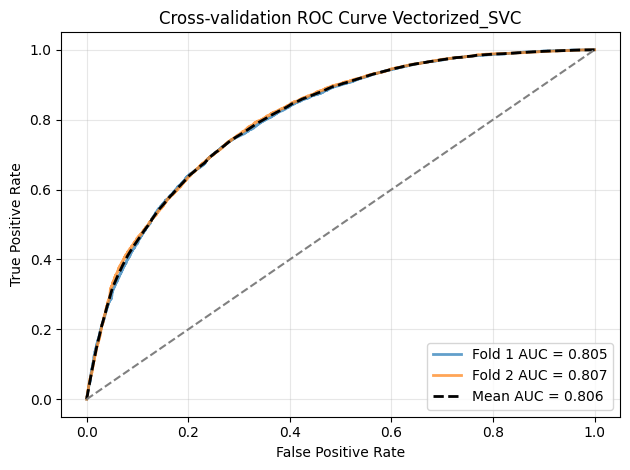

Metrics:
  Accuracies:  [0.7245466155810983, 0.7292326555635026]
  Precisions: [0.6997079225994889, 0.7017797452344385]
  Recalls:    [0.7848075348075348, 0.7953312173645951]
  F1 Scores:  [0.7398185678440455, 0.7456325590324439]
  AUC:       [0.8048837287327653, 0.8073018220635431]
Average Metrics:
  Accuracy:  0.727
  Precision: 0.701
  Recall:    0.790
  F1 Score:  0.743
  AUC:       0.806


In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score
from sklearn.svm import SVC
import pandas as pd
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc



def load_code2seq_file(file_path):
    data = []
    labels = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            label, *contexts = line.strip().split()
            data.append(" ".join(contexts))
            labels.append(0 if label == 'human' else 1)
    return data, labels

X, y = load_code2seq_file("data/code2seq_dataset.txt")

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 5))),
    ('classifier', SVC(kernel='rbf', probability=True, random_state=42))
])


cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

accuracies = []
precisions = []
recalls = []
f1_scores = []
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

for i, (train_idx, test_idx) in enumerate(cv.split(X, y)):
    X_train, X_test = [X[i] for i in train_idx], [X[i] for i in test_idx]
    y_train, y_test = [y[i] for i in train_idx], [y[i] for i in test_idx]
    

    pipeline.fit(X_train, y_train)
    

    y_pred = pipeline.predict(X_test)
    y_prob = pipeline.predict_proba(X_test)[:, 1]
    

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    

    accuracies.append(acc)
    precisions.append(prec)
    recalls.append(rec)
    f1_scores.append(f1)
    

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    
    aucs.append(roc_auc)

    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    

    plt.plot(fpr, tpr, lw=2, alpha=0.7, label=f'Fold {i+1} AUC = {roc_auc:.3f}')

    

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='black', linestyle='--', label=f'Mean AUC = {mean_auc:.3f}', lw=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Cross-validation ROC Curve Vectorized_SVC')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


print("Metrics:")
print(f"  Accuracies:  {accuracies}")
print(f"  Precisions: {precisions}")
print(f"  Recalls:    {recalls}")
print(f"  F1 Scores:  {f1_scores}")
print(f"  AUC:       {aucs}")



print("Average Metrics:")
print(f"  Accuracy:  {np.mean(accuracies):.3f}")
print(f"  Precision: {np.mean(precisions):.3f}")
print(f"  Recall:    {np.mean(recalls):.3f}")
print(f"  F1 Score:  {np.mean(f1_scores):.3f}")
print(f"  AUC:       {mean_auc:.3f}")

# Random Forest using AST + TFIDF

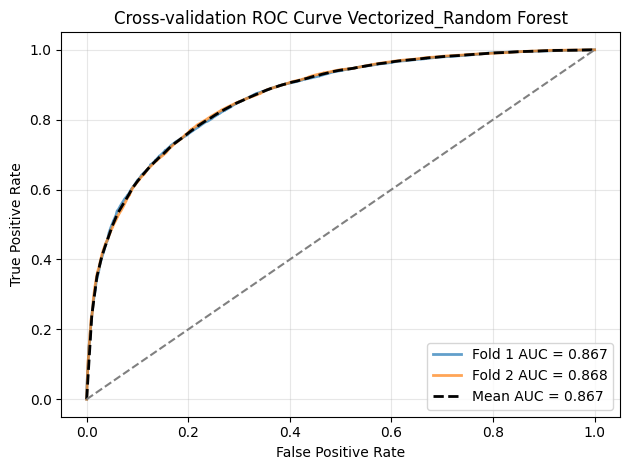

Metrics:
  Accuracies:  [0.7788505747126436, 0.7822621845304997]
  Precisions: [0.7634919096986726, 0.7672589571803088]
  Recalls:    [0.8067158067158067, 0.8090508856353026]
  F1 Scores:  [0.7845089352381901, 0.7876009169739858]
  AUC:       [0.8672356883009987, 0.8678041488952197]
Average Metrics:
  Accuracy:  0.781
  Precision: 0.765
  Recall:    0.808
  F1 Score:  0.786
  AUC:       0.867


In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc



def load_code2seq_file(file_path):
    data = []
    labels = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            label, *contexts = line.strip().split()
            data.append(" ".join(contexts))
            labels.append(0 if label == 'human' else 1)
    return data, labels

X, y = load_code2seq_file("data/code2seq_dataset.txt")


pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 5))),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])




cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)


accuracies = []
precisions = []
recalls = []
f1_scores = []
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)


for i, (train_idx, test_idx) in enumerate(cv.split(X, y)):
    X_train, X_test = [X[i] for i in train_idx], [X[i] for i in test_idx]
    y_train, y_test = [y[i] for i in train_idx], [y[i] for i in test_idx]
    

    pipeline.fit(X_train, y_train)
    

    y_pred = pipeline.predict(X_test)
    y_prob = pipeline.predict_proba(X_test)[:, 1]
    

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    

    accuracies.append(acc)
    precisions.append(prec)
    recalls.append(rec)
    f1_scores.append(f1)

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    
    aucs.append(roc_auc)
    

    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    
  
    plt.plot(fpr, tpr, lw=2, alpha=0.7, label=f'Fold {i+1} AUC = {roc_auc:.3f}')

    

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='black', linestyle='--', label=f'Mean AUC = {mean_auc:.3f}', lw=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Cross-validation ROC Curve Vectorized_Random Forest')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Print average metrics
print("Metrics:")
print(f"  Accuracies:  {accuracies}")
print(f"  Precisions: {precisions}")
print(f"  Recalls:    {recalls}")
print(f"  F1 Scores:  {f1_scores}")
print(f"  AUC:       {aucs}")


# Print average metrics
print("Average Metrics:")
print(f"  Accuracy:  {np.mean(accuracies):.3f}")
print(f"  Precision: {np.mean(precisions):.3f}")
print(f"  Recall:    {np.mean(recalls):.3f}")
print(f"  F1 Score:  {np.mean(f1_scores):.3f}")
print(f"  AUC:       {mean_auc:.3f}")

# Contrastive Representation Learning using AST (2 Fold CV)

In [21]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

def plot_mean_roc_curve(tprs, aucs, mean_fpr):
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.figure(figsize=(8, 6))
    for i, (tpr, auc_val) in enumerate(zip(tprs, aucs)):
        plt.plot(mean_fpr, tpr, lw=2, label=f'Fold {i+1} AUC = {auc_val:.2f}')
    plt.plot(mean_fpr, mean_tpr, color='black', linestyle='--', label=f'Mean AUC = {mean_auc:.3f}', lw=2)
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Cross-validation ROC Curve')
    plt.legend(loc='lower right')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

def visualize_embeddings(embeddings_list, labels_list, method='tsne'):
    embeddings = embeddings_list[0]
    labels = labels_list[0]

    if method == 'tsne':
        reducer = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
    elif method == 'pca':
        reducer = PCA(n_components=2)
    else:
        raise ValueError("Method must be 'tsne' or 'pca'")

    reduced = reducer.fit_transform(embeddings)

    plt.figure(figsize=(7, 6))
    for label in np.unique(labels):
        idx = np.where(labels == label)
        plt.scatter(reduced[idx, 0], reduced[idx, 1], label=f'Class {label}', alpha=0.7, s=30)

    plt.title(f"{method.upper()} - Fold 1")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def triplet_loss(anchor, positives, negatives, margin=0.3):
    anchor = tf.nn.l2_normalize(anchor, axis=-1)
    positives = tf.nn.l2_normalize(positives, axis=-1)
    negatives = tf.nn.l2_normalize(negatives, axis=-1)

    pos_sim = tf.reduce_sum(anchor[:, tf.newaxis, :] * positives, axis=-1)
    neg_sim = tf.reduce_sum(anchor[:, tf.newaxis, :] * negatives, axis=-1)

    pos_dist = 1 - pos_sim
    neg_dist = 1 - neg_sim

    pos_sum = tf.reduce_sum(pos_dist, axis=1)
    neg_sum = tf.reduce_sum(neg_dist, axis=1)

    loss = tf.maximum(pos_sum - neg_sum + margin, 0.0)
    return tf.reduce_mean(loss)

def build_deep_encoder(input_dim, projection_dim=64):
    inputs = Input(shape=(input_dim,))
    x = Dense(512, activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    embedding = Dense(projection_dim, activation='relu')(x)
    return Model(inputs, embedding, name="deep_encoder")

def build_strong_classifier(embed_dim):
    inputs = Input(shape=(embed_dim,))
    x = Dense(128, activation='relu')(inputs)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(1, activation='sigmoid')(x)
    return Model(inputs, output, name="classifier")

def generate_triplets(X, y, num_pos_neg=4):
    anchors, positives, negatives, labels = [], [], [], []
    label_indices = {label: np.where(y == label)[0] for label in np.unique(y)}

    for i in range(len(X)):
        anchor = X[i]
        label = y[i]

        pos = [j for j in label_indices[label] if j != i]
        neg = list(np.concatenate([label_indices[l] for l in label_indices if l != label]))

        if len(pos) < num_pos_neg or len(neg) < num_pos_neg:
            continue

        selected_pos = np.random.choice(pos, num_pos_neg, replace=False)
        selected_neg = np.random.choice(neg, num_pos_neg, replace=False)

        anchors.append(anchor)
        positives.append(X[selected_pos])
        negatives.append(X[selected_neg])
        labels.append(label)

    return np.array(anchors), np.array(positives), np.array(negatives), np.array(labels)

def train_powerful_contrastive_classifier(texts, labels, epochs=20, batch_size=128):
    if hasattr(texts, 'values'):
        texts = texts.values
    if hasattr(labels, 'values'):
        labels = labels.values

    X = np.array(texts)
    y = np.array(labels)

    mean_fpr = np.linspace(0, 1, 100)
    tprs, aucs = [], []
    embed_all, label_all = [], []

    cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y), 1):
        print(f"\n--- Fold {fold} ---")

        X_train, y_train = X[train_idx], y[train_idx]
        X_val, y_val = X[val_idx], y[val_idx]

        input_dim = X_train.shape[1]
        encoder = build_deep_encoder(input_dim)
        classifier = build_strong_classifier(64)

        optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
        loss_fn = tf.keras.losses.BinaryCrossentropy()

        anchors, positives, negatives, labels_triplet = generate_triplets(X_train, y_train)

        for epoch in range(epochs):
            print(f"Epoch {epoch+1}/{epochs}")
            total_triplet, total_class = 0.0, 0.0
            batches = 0

            for i in range(0, len(anchors), batch_size):
                a_batch = anchors[i:i + batch_size]
                p_batch = positives[i:i + batch_size]
                n_batch = negatives[i:i + batch_size]
                y_batch = labels_triplet[i:i + batch_size].reshape(-1, 1)

                with tf.GradientTape() as tape:
                    a_embed = encoder(a_batch, training=True)
                    p_embed = tf.stack([encoder(p_batch[:, j], training=True) for j in range(p_batch.shape[1])], axis=1)
                    n_embed = tf.stack([encoder(n_batch[:, j], training=True) for j in range(n_batch.shape[1])], axis=1)

                    loss_trip = triplet_loss(a_embed, p_embed, n_embed)
                    preds = classifier(a_embed, training=True)
                    loss_cls = loss_fn(y_batch, preds)
                    total_loss = loss_trip + loss_cls

                grads = tape.gradient(total_loss, encoder.trainable_variables + classifier.trainable_variables)
                optimizer.apply_gradients(zip(grads, encoder.trainable_variables + classifier.trainable_variables))

                total_triplet += loss_trip.numpy()
                total_class += loss_cls.numpy()
                batches += 1

            print(f"Triplet Loss: {total_triplet/batches:.4f}, Classification Loss: {total_class/batches:.4f}")

        test_embed = encoder.predict(X_val)
        y_probs = classifier.predict(test_embed)
        y_pred = (y_probs > 0.5).astype(int).flatten()

        fpr, tpr, _ = roc_curve(y_val, y_probs)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        auc_score = auc(fpr, tpr)
        aucs.append(auc_score)

        acc = accuracy_score(y_val, y_pred)
        prec = precision_score(y_val, y_pred)
        rec = recall_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred)

        print(f"Fold {fold} Metrics:")
        print(f"  Accuracy : {acc:.4f}")
        print(f"  Precision: {prec:.4f}")
        print(f"  Recall   : {rec:.4f}")
        print(f"  F1 Score : {f1:.4f}")
        print(f"  AUC      : {auc_score:.4f}")

        embed_all.append(test_embed)
        label_all.append(y_val)

    plot_mean_roc_curve(tprs, aucs, mean_fpr)
    sampled_embed = embed_all[0][::10]  # every 10th sample
    sampled_label = label_all[0][::10]
    visualize_embeddings([sampled_embed], [sampled_label], method='tsne')


--- Fold 1 ---
Epoch 1/20
Triplet Loss: 0.3251, Classification Loss: 0.7073
Epoch 2/20
Triplet Loss: 0.3245, Classification Loss: 0.6953
Epoch 3/20
Triplet Loss: 0.3253, Classification Loss: 0.6942
Epoch 4/20
Triplet Loss: 0.3266, Classification Loss: 0.6943
Epoch 5/20
Triplet Loss: 0.3221, Classification Loss: 0.6941
Epoch 6/20
Triplet Loss: 0.3238, Classification Loss: 0.6931
Epoch 7/20
Triplet Loss: 0.3190, Classification Loss: 0.6938
Epoch 8/20
Triplet Loss: 0.3195, Classification Loss: 0.6936
Epoch 9/20
Triplet Loss: 0.3184, Classification Loss: 0.6938
Epoch 10/20
Triplet Loss: 0.3179, Classification Loss: 0.6932
Epoch 11/20
Triplet Loss: 0.3131, Classification Loss: 0.6935
Epoch 12/20
Triplet Loss: 0.3167, Classification Loss: 0.6934
Epoch 13/20
Triplet Loss: 0.3097, Classification Loss: 0.6932
Epoch 14/20
Triplet Loss: 0.3115, Classification Loss: 0.6933
Epoch 15/20
Triplet Loss: 0.3079, Classification Loss: 0.6932
Epoch 16/20
Triplet Loss: 0.3087, Classification Loss: 0.6933
E

Fold 1 Metrics:
  Accuracy : 0.4990
  Precision: 0.4990
  Recall   : 1.0000
  F1 Score : 0.6658
  AUC      : 0.5000

--- Fold 2 ---
Epoch 1/20
Triplet Loss: 0.3248, Classification Loss: 0.7010
Epoch 2/20
Triplet Loss: 0.3278, Classification Loss: 0.6941
Epoch 3/20
Triplet Loss: 0.3237, Classification Loss: 0.6939
Epoch 4/20
Triplet Loss: 0.3267, Classification Loss: 0.6938
Epoch 5/20
Triplet Loss: 0.3258, Classification Loss: 0.6938
Epoch 6/20
Triplet Loss: 0.3196, Classification Loss: 0.6931
Epoch 7/20
Triplet Loss: 0.3245, Classification Loss: 0.6935
Epoch 8/20
Triplet Loss: 0.3216, Classification Loss: 0.6934
Epoch 9/20
Triplet Loss: 0.3207, Classification Loss: 0.6934
Epoch 10/20
Triplet Loss: 0.3182, Classification Loss: 0.6934
Epoch 11/20
Triplet Loss: 0.3189, Classification Loss: 0.6932
Epoch 12/20
Triplet Loss: 0.3169, Classification Loss: 0.6933
Epoch 13/20
Triplet Loss: 0.3126, Classification Loss: 0.6932
Epoch 14/20
Triplet Loss: 0.3154, Classification Loss: 0.6932
Epoch 15/

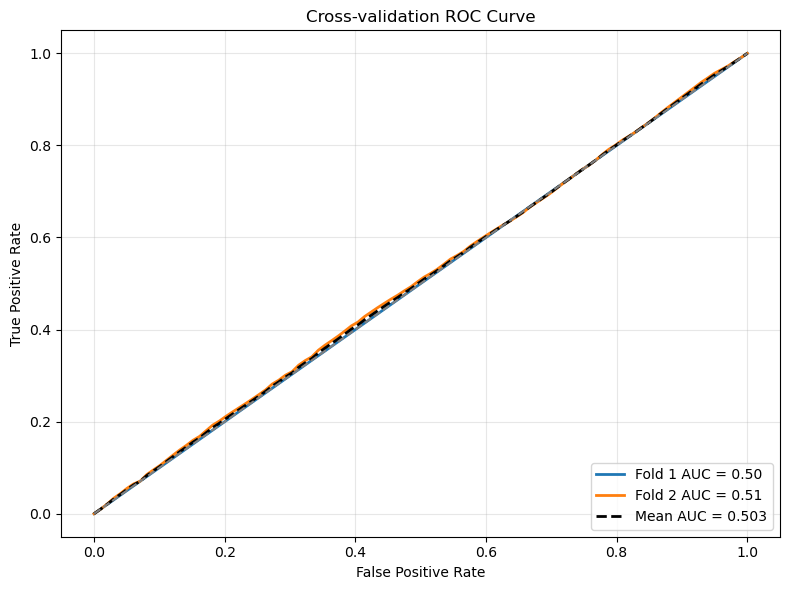

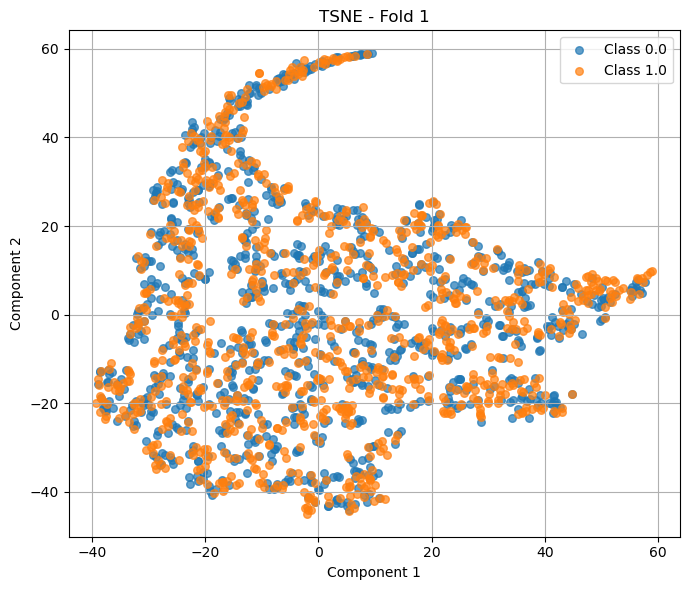

In [22]:
results = train_powerful_contrastive_classifier(X_c, y_c)

# Contrastive Representation Learning using AST + TFIDF (2 Fold CV)

In [23]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import numpy as np

def load_code2seq_file(file_path):
    data = []
    labels = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            label, *contexts = line.strip().split()
            data.append(" ".join(contexts))
            labels.append(0 if label == 'human' else 1)
    return data, labels


def plot_mean_roc_curve(tprs, aucs, mean_fpr):
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.figure(figsize=(8, 6))
    for i, (tpr, auc_val) in enumerate(zip(tprs, aucs)):
        plt.plot(mean_fpr, tpr, lw=2, label=f'Fold {i+1} AUC = {auc_val:.2f}')
    plt.plot(mean_fpr, mean_tpr, color='black', linestyle='--', label=f'Mean AUC = {mean_auc:.3f}', lw=2)
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Cross-validation ROC Curve')
    plt.legend(loc='lower right')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


def visualize_embeddings(embeddings_list, labels_list, method='tsne'):
    embeddings = embeddings_list[0]
    labels = labels_list[0]

    if method == 'tsne':
        reducer = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
    elif method == 'pca':
        reducer = PCA(n_components=2)
    else:
        raise ValueError("Method must be 'tsne' or 'pca'")

    reduced = reducer.fit_transform(embeddings)

    plt.figure(figsize=(7, 6))
    for label in np.unique(labels):
        idx = np.where(labels == label)
        plt.scatter(reduced[idx, 0], reduced[idx, 1], label=f'Class {label}', alpha=0.7, s=30)

    plt.title(f"{method.upper()} - Fold 1")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def triplet_loss(anchor, positives, negatives, margin=0.3):
    anchor = tf.nn.l2_normalize(anchor, axis=-1)
    positives = tf.nn.l2_normalize(positives, axis=-1)
    negatives = tf.nn.l2_normalize(negatives, axis=-1)

    pos_sim = tf.reduce_sum(anchor[:, tf.newaxis, :] * positives, axis=-1)
    neg_sim = tf.reduce_sum(anchor[:, tf.newaxis, :] * negatives, axis=-1)

    pos_dist = 1 - pos_sim
    neg_dist = 1 - neg_sim

    pos_sum = tf.reduce_sum(pos_dist, axis=1)
    neg_sum = tf.reduce_sum(neg_dist, axis=1)

    loss = tf.maximum(pos_sum - neg_sum + margin, 0.0)
    return tf.reduce_mean(loss)


def build_deep_encoder(input_dim, projection_dim=64):
    inputs = Input(shape=(input_dim,))
    x = Dense(512, activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    embedding = Dense(projection_dim, activation='relu')(x)
    return Model(inputs, embedding, name="deep_encoder")


def build_strong_classifier(embed_dim):
    inputs = Input(shape=(embed_dim,))
    x = Dense(128, activation='relu')(inputs)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(1, activation='sigmoid')(x)
    return Model(inputs, output, name="classifier")


def generate_triplets(X, y, num_pos_neg=4):
    anchors, positives, negatives, labels = [], [], [], []
    label_indices = {label: np.where(y == label)[0] for label in np.unique(y)}

    for i in range(len(X)):
        anchor = X[i]
        label = y[i]

        pos = [j for j in label_indices[label] if j != i]
        neg = list(np.concatenate([label_indices[l] for l in label_indices if l != label]))

        if len(pos) < num_pos_neg or len(neg) < num_pos_neg:
            continue

        selected_pos = np.random.choice(pos, num_pos_neg, replace=False)
        selected_neg = np.random.choice(neg, num_pos_neg, replace=False)

        anchors.append(anchor)
        positives.append(X[selected_pos])
        negatives.append(X[selected_neg])
        labels.append(label)

    return np.array(anchors), np.array(positives), np.array(negatives), np.array(labels)


def train_powerful_contrastive_classifier(texts, labels, epochs=20, batch_size=128):
    if hasattr(texts, 'values'):
        texts = texts.values
    if hasattr(labels, 'values'):
        labels = labels.values

    vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1, 2))
    X = vectorizer.fit_transform(texts).toarray()
    y = np.array(labels)

    mean_fpr = np.linspace(0, 1, 100)
    tprs, aucs = [], []
    embed_all, label_all = [], []

    cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y), 1):
        print(f"\n--- Fold {fold} ---")

        X_train, y_train = X[train_idx], y[train_idx]
        X_val, y_val = X[val_idx], y[val_idx]

        input_dim = X_train.shape[1]
        encoder = build_deep_encoder(input_dim)
        classifier = build_strong_classifier(64)

        optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
        loss_fn = tf.keras.losses.BinaryCrossentropy()

        anchors, positives, negatives, labels_triplet = generate_triplets(X_train, y_train)

        for epoch in range(epochs):
            print(f"Epoch {epoch+1}/{epochs}")
            total_triplet, total_class = 0.0, 0.0
            batches = 0

            for i in range(0, len(anchors), batch_size):
                a_batch = anchors[i:i + batch_size]
                p_batch = positives[i:i + batch_size]
                n_batch = negatives[i:i + batch_size]
                y_batch = labels_triplet[i:i + batch_size].reshape(-1, 1)

                with tf.GradientTape() as tape:
                    a_embed = encoder(a_batch, training=True)
                    p_embed = tf.stack([encoder(p_batch[:, j], training=True) for j in range(p_batch.shape[1])], axis=1)
                    n_embed = tf.stack([encoder(n_batch[:, j], training=True) for j in range(n_batch.shape[1])], axis=1)

                    loss_trip = triplet_loss(a_embed, p_embed, n_embed)
                    preds = classifier(a_embed, training=True)
                    loss_cls = loss_fn(y_batch, preds)
                    total_loss = loss_trip + loss_cls

                grads = tape.gradient(total_loss, encoder.trainable_variables + classifier.trainable_variables)
                optimizer.apply_gradients(zip(grads, encoder.trainable_variables + classifier.trainable_variables))

                total_triplet += loss_trip.numpy()
                total_class += loss_cls.numpy()
                batches += 1

            print(f"Triplet Loss: {total_triplet/batches:.4f}, Classification Loss: {total_class/batches:.4f}")

        test_embed = encoder.predict(X_val)
        y_probs = classifier.predict(test_embed)
        y_pred = (y_probs > 0.5).astype(int).flatten()

        fpr, tpr, _ = roc_curve(y_val, y_probs)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        auc_score = auc(fpr, tpr)
        aucs.append(auc_score)

        acc = accuracy_score(y_val, y_pred)
        prec = precision_score(y_val, y_pred)
        rec = recall_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred)

        print(f"Fold {fold} Metrics:")
        print(f"  Accuracy : {acc:.4f}")
        print(f"  Precision: {prec:.4f}")
        print(f"  Recall   : {rec:.4f}")
        print(f"  F1 Score : {f1:.4f}")
        print(f"  AUC      : {auc_score:.4f}")

        embed_all.append(test_embed)
        label_all.append(y_val)

    plot_mean_roc_curve(tprs, aucs, mean_fpr)
    sampled_embed = embed_all[0][::10]  # every 10th sample
    sampled_label = label_all[0][::10]
    visualize_embeddings([sampled_embed], [sampled_label], method='tsne')



--- Fold 1 ---
Epoch 1/20
Triplet Loss: 0.2884, Classification Loss: 0.6378
Epoch 2/20
Triplet Loss: 0.2822, Classification Loss: 0.6148
Epoch 3/20
Triplet Loss: 0.2777, Classification Loss: 0.6069
Epoch 4/20
Triplet Loss: 0.2697, Classification Loss: 0.6014
Epoch 5/20
Triplet Loss: 0.2660, Classification Loss: 0.5910
Epoch 6/20
Triplet Loss: 0.2594, Classification Loss: 0.5842
Epoch 7/20
Triplet Loss: 0.2581, Classification Loss: 0.5833
Epoch 8/20
Triplet Loss: 0.2532, Classification Loss: 0.5761
Epoch 9/20
Triplet Loss: 0.2453, Classification Loss: 0.5709
Epoch 10/20
Triplet Loss: 0.2436, Classification Loss: 0.5644
Epoch 11/20
Triplet Loss: 0.2377, Classification Loss: 0.5557
Epoch 12/20
Triplet Loss: 0.2389, Classification Loss: 0.5590
Epoch 13/20
Triplet Loss: 0.2332, Classification Loss: 0.5523
Epoch 14/20
Triplet Loss: 0.2329, Classification Loss: 0.5505
Epoch 15/20
Triplet Loss: 0.2298, Classification Loss: 0.5441
Epoch 16/20
Triplet Loss: 0.2240, Classification Loss: 0.5396
E

Epoch 1/20
Triplet Loss: 0.2928, Classification Loss: 0.6444
Epoch 2/20
Triplet Loss: 0.2881, Classification Loss: 0.6230
Epoch 3/20
Triplet Loss: 0.2806, Classification Loss: 0.6114
Epoch 4/20
Triplet Loss: 0.2792, Classification Loss: 0.6053
Epoch 5/20
Triplet Loss: 0.2699, Classification Loss: 0.5998
Epoch 6/20
Triplet Loss: 0.2643, Classification Loss: 0.5911
Epoch 7/20
Triplet Loss: 0.2630, Classification Loss: 0.5873
Epoch 8/20
Triplet Loss: 0.2566, Classification Loss: 0.5807
Epoch 9/20
Triplet Loss: 0.2563, Classification Loss: 0.5730
Epoch 10/20
Triplet Loss: 0.2493, Classification Loss: 0.5686
Epoch 11/20
Triplet Loss: 0.2477, Classification Loss: 0.5689
Epoch 12/20
Triplet Loss: 0.2454, Classification Loss: 0.5614
Epoch 13/20
Triplet Loss: 0.2394, Classification Loss: 0.5528
Epoch 14/20
Triplet Loss: 0.2371, Classification Loss: 0.5552
Epoch 15/20
Triplet Loss: 0.2319, Classification Loss: 0.5472
Epoch 16/20
Triplet Loss: 0.2307, Classification Loss: 0.5448
Epoch 17/20
Tripl

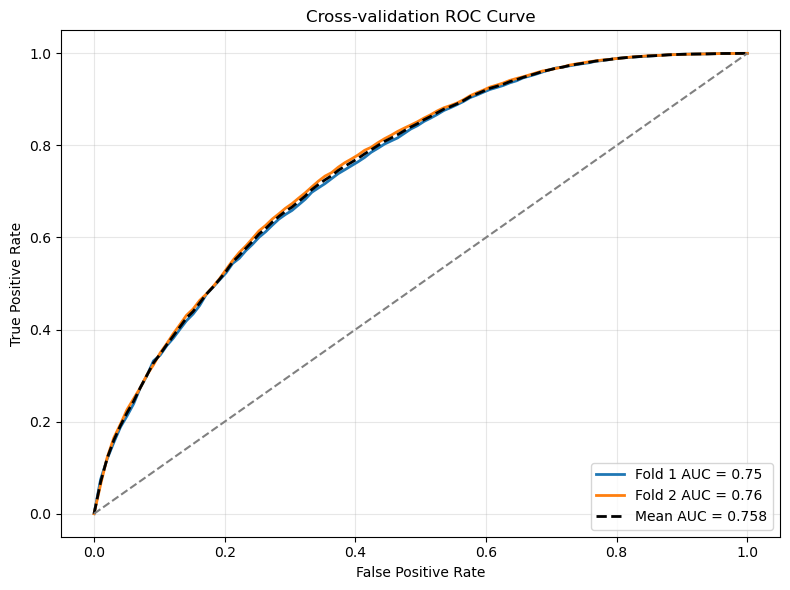

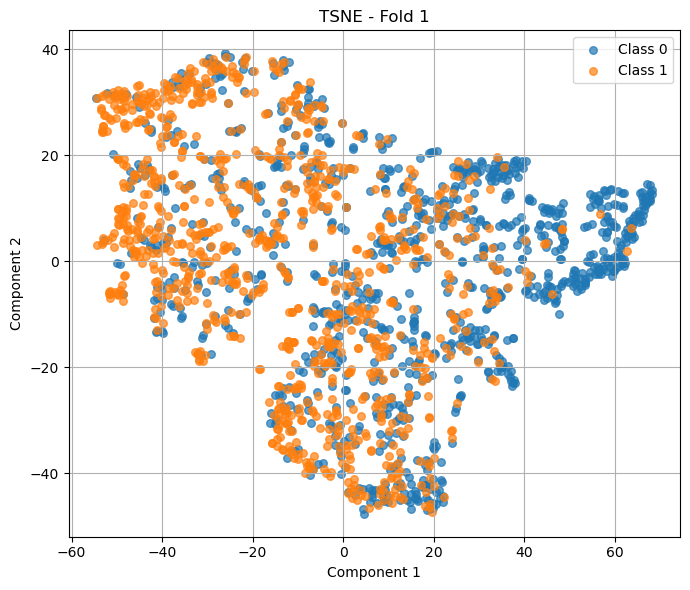

In [24]:
x, y = load_code2seq_file("data/code2seq_dataset.txt")
results = train_powerful_contrastive_classifier(x, y)